#**High-Precision SMS Spam Classification with BERT**

##Download the dataset

https://archive.ics.uci.edu/dataset/228/sms+spam+collection

##Import libraries

In [ ]:
import os
import re
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW

from google.colab import drive

##1. Data visualization and preprocessing

In [ ]:
drive.mount('/content/drive')
path = '/content/drive/My Drive/SMS_Classifier/SMSSpamCollection'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_orig = pd.read_csv(path , sep='\t', header=None, names=['label', 'text'])
df_orig.to_csv('SMSSpamCollection.csv', index=False, encoding='utf-8')

df = df_orig.copy()


In [ ]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


1.1 Checking whether there are null values.

In [ ]:
df.isnull().sum()

,0
label,0
text,0


1.2 Transforming atribute 'label' into integer:


*   'ham' = 0
*   'spam' = 1



In [ ]:
df['label'] = (df['label'] == 'spam').astype(int)

1.3 Plotting the label distribution reveals a large imbalance.

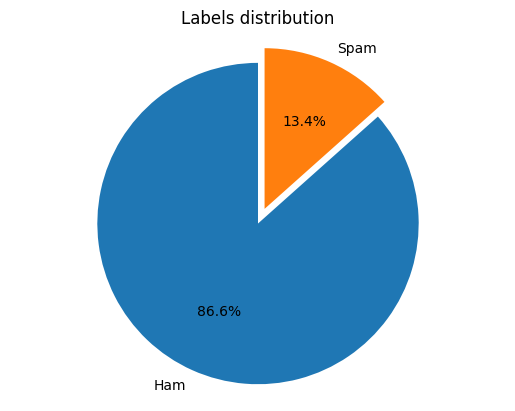

In [ ]:
labels = ['Ham', 'Spam']
counts = df['label'].value_counts()
sizes = [(counts[0] / counts.sum()) * 100, (counts[1] / counts.sum()) * 100]

plt.pie(sizes, labels = labels, autopct = '%1.1f%%', startangle=90, explode=(0, 0.1))
plt.axis('equal')
plt.title('Labels distribution')
plt.show()

In [ ]:
print("\n" + "="*37)
print("             DATA SAMPLE")
print("="*37)
print("> Ham SMS:\n", df[df['label'] == 0]['text'].iloc[0], "\n")
print("> Spam SMS:\n", df[df['label'] == 1]['text'].iloc[0])


             DATA SAMPLE
> Ham SMS:
 Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... 

> Spam SMS:
 Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


1.4 Knowing the length of SMS messages is important to define the tokenizer. This make it easier for us to set the value of max_length attribute.

Text(0.5, 0, 'Tocken count')

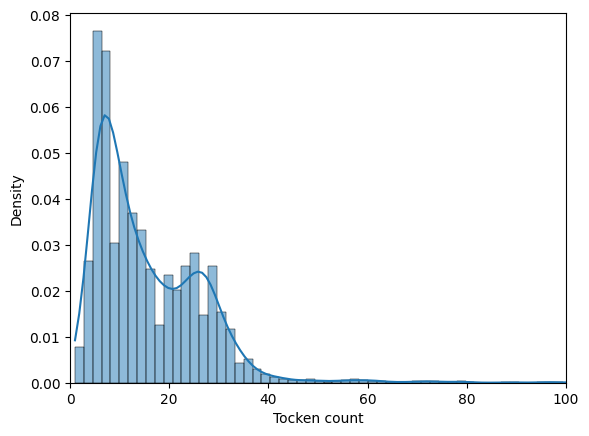

In [ ]:
sms_len = []
for sms in df['text']:
  tokens = sms.split(" ")
  sms_len.append(len(tokens))

sns.histplot(sms_len, kde=True, stat="density")
plt.xlim([0,100])
plt.xlabel('Tocken count')

1.5 At this point is important to distinguish between:

*   Keywords: relevant words that add meaning to the message.
*   Stopwords: words that do not contribute a central meaneaning to the context of a text, e.g. articles, prepositions.

Take a look to the following bar charts.


In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def get_top_keywords_by_label(df, label_value, n=20):
  text_corpus = " ".join(df[df['label'] == label_value]['text'].str.lower())

  keywords = [word for word in text_corpus.split() if word not in stop_words]

  counts = Counter(keywords)

  return pd.DataFrame(counts.most_common(n), columns = ['Keyword', 'Frequency'])

In [ ]:
top_ham = get_top_keywords_by_label(df, label_value = 0)
top_spam = get_top_keywords_by_label(df, label_value = 1)

In [ ]:
def plot_top_keywords(df_top, title, color):
  plt.figure(figsize=(10,6))
  sns.barplot(x='Frequency', y = 'Keyword', hue ='Keyword', legend = False, data=df_top, palette=color)
  plt.title(title, fontsize=15)
  plt.show()

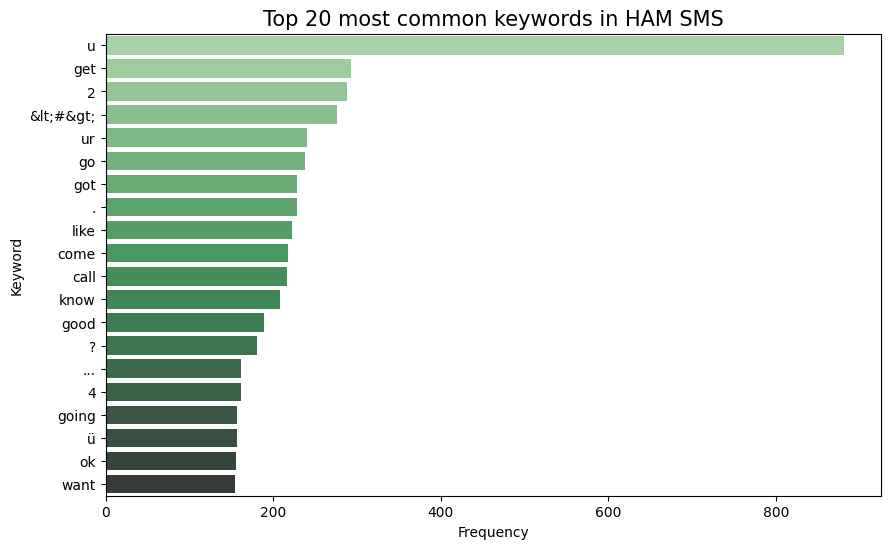

In [ ]:
plot_top_keywords(top_ham, 'Top 20 most common keywords in HAM SMS', 'Greens_d')

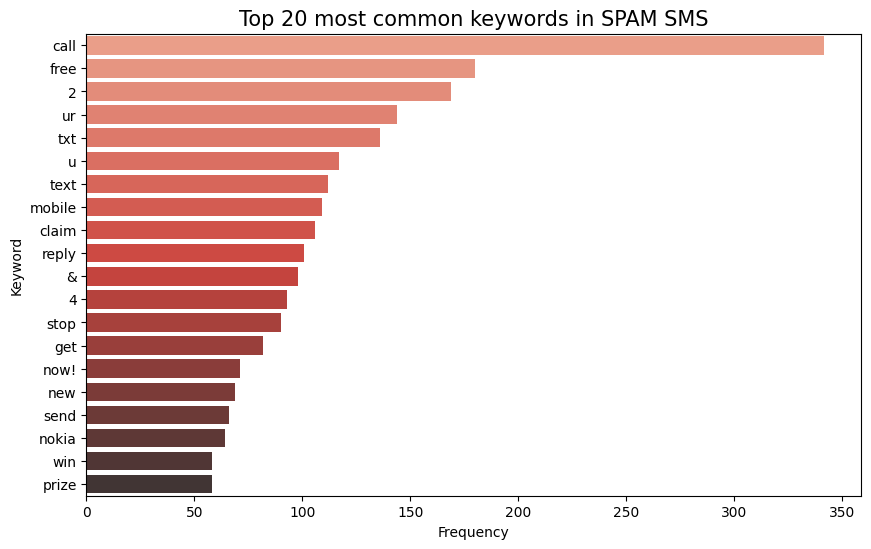

In [ ]:
plot_top_keywords(top_spam, 'Top 20 most common keywords in SPAM SMS', 'Reds_d')

1.6 In this particular case I do not need to clean the texts by removing special characters, URLs or contractions because the applied model "understand" them. I only standarise ellipses to simplify the tokenization.

In [ ]:
def clean_dots(text):
  text = re.sub(r'\.{2,}', '...', text)
  return text

In [ ]:
df['text'] = df['text'].apply(clean_dots)

##2. Dividing data into training, validation and test sets

In [ ]:
train_set, test_set = train_test_split(df, test_size = 0.1, random_state = 42, stratify = df['label'])
val_set, test_set = train_test_split(test_set, test_size = 0.5, random_state = 42, stratify = test_set['label'])

X_train = train_set['text'].copy()
y_train = train_set['label'].copy()

X_val = val_set['text'].copy()
y_val = val_set['label'].copy()

X_test = test_set['text'].copy()
y_test = test_set['label'].copy()

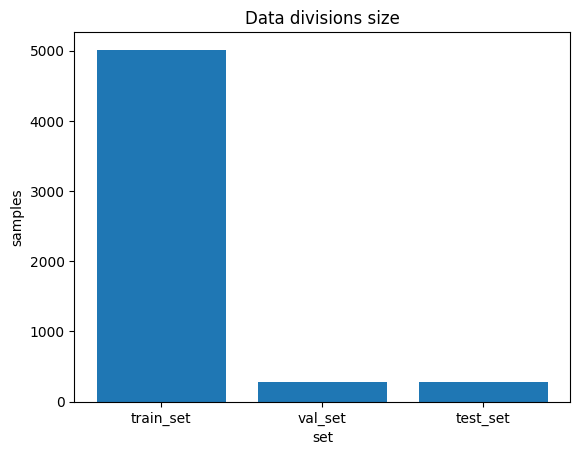

In [ ]:
data = [len(train_set), len(val_set), len(test_set)]
labels = ['train_set', 'val_set', 'test_set']

plt.figure()
plt.bar(labels, data)
plt.xlabel('set')
plt.ylabel('samples')
plt.title('Data divisions size')
plt.show()

##3. Data tokenization

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def tokenize_data(texts):
  return tokenizer.batch_encode_plus(
      texts.tolist(),
      add_special_tokens = True,
      max_length = 64,
      padding = 'max_length',
      truncation = True,
      return_attention_mask = True,
      return_tensors = 'pt'
  )

In [ ]:
train_tokens = tokenize_data(X_train)
val_tokens = tokenize_data(X_val)
test_tokens = tokenize_data(X_test)

train_seq = train_tokens['input_ids']
train_mask = train_tokens['attention_mask']
train_y = torch.tensor(y_train.values)

val_seq = val_tokens['input_ids']
val_mask = val_tokens['attention_mask']
val_y = torch.tensor(y_val.values)

test_seq = test_tokens['input_ids']
test_mask = test_tokens['attention_mask']
test_y = torch.tensor(y_test.values)

In [ ]:
print("\n" + "="*50)
print("             DATA TOKENIZATION SAMPLE")
print("="*50)

print(X_train.iloc[0])
print(tokenizer.convert_ids_to_tokens(train_seq[0]))
print(train_seq[0])
print(train_mask[0])


             DATA TOKENIZATION SAMPLE
Heehee that was so funny tho
['[CLS]', 'He', '##eh', '##ee', 'that', 'was', 'so', 'funny', 'th', '##o', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
tensor([  101,  1124, 10486,  3051,  1115,  1108,  1177,  6276, 24438,  1186,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,   

##4. Dataloader setup

4.1 Packing the tensors.

In [ ]:
train_data = TensorDataset(train_seq, train_mask, train_y)
val_data = TensorDataset(val_seq, val_mask, val_y)
test_data = TensorDataset(test_seq, test_mask, test_y)

4.2 Creating the dataloaders.

In [ ]:
batch_size = 32

train_dataloader = DataLoader(
    train_data,
    sampler = RandomSampler(train_data),
    batch_size = batch_size
)

val_dataloader = DataLoader(
    val_data,
    sampler = SequentialSampler(val_data),
    batch_size = batch_size
)

test_dataloader = DataLoader(
    test_data,
    sampler = SequentialSampler(test_data),
    batch_size = batch_size
)


## 5. BERT

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


5.1 Moving the model to the GPU if it is available.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

5.2 Defining the optimizer and the scheduler.

I use a scheduler to avoid overfitting caused by a high and constant learning rate. Starting from a peak value of 2e-5, the scheduler decreases the learning rate linearly throughout the training, reaching zero by the final epoch.

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                  )
epochs = 3

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)


5.3 Model training loop.

In [ ]:
for epoch_i in range (0, epochs):
  model.train()

  progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch_i +1}/{epochs}")

  for batch in progress_bar:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    token_type_ids = None,
                    attention_mask = b_input_mask,
                    labels = b_labels)

    loss = outputs.loss
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    scheduler.step()

Epoch 3/3: 100%|██████████| 157/157 [00:53<00:00,  2.93it/s]


5.4 Model validation.

In [ ]:
model.eval()
val_all_preds = []
val_all_labels = []

for batch in val_dataloader:
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)

  with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  logits = outputs.logits
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  val_all_preds.extend(np.argmax(logits, axis=1).flatten())
  val_all_labels.extend(label_ids.flatten())


5.5 Model evaluation.

In [ ]:
model.eval()
test_all_preds = []
test_all_labels = []

for batch in test_dataloader:
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)

  with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  logits = outputs.logits
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  test_all_preds.extend(np.argmax(logits, axis=1).flatten())
  test_all_labels.extend(label_ids.flatten())


##6. Results

In [ ]:
print("\n" + "="*60)
print("                    VALIDATION REPORT")
print("="*60)

print(classification_report(val_all_labels, val_all_preds, target_names = ['Ham', 'Spam']))

print("\n" + "="*60)
print("             FINAL PERFORMANCE REPORT (TEST SET)")
print("="*60)

print(classification_report(test_all_labels, test_all_preds, target_names = ['Ham', 'Spam']))


                    VALIDATION REPORT
              precision    recall  f1-score   support

         Ham       1.00      1.00      1.00       241
        Spam       0.97      0.97      0.97        38

    accuracy                           0.99       279
   macro avg       0.98      0.98      0.98       279
weighted avg       0.99      0.99      0.99       279


             FINAL PERFORMANCE REPORT (TEST SET)
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       242
        Spam       0.94      0.92      0.93        37

    accuracy                           0.98       279
   macro avg       0.97      0.96      0.96       279
weighted avg       0.98      0.98      0.98       279



##7. Saving BERT classification model.

In [ ]:
output_dir = "/content/drive/My Drive/SMS_Classifier/bert_spam_model"
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


('/content/drive/My Drive/SMS_Classifier/bert_spam_model/tokenizer_config.json',
 '/content/drive/My Drive/SMS_Classifier/bert_spam_model/special_tokens_map.json',
 '/content/drive/My Drive/SMS_Classifier/bert_spam_model/vocab.txt',
 '/content/drive/My Drive/SMS_Classifier/bert_spam_model/added_tokens.json')